# Testeador de Modelos
## Datos Básicos y Rutinas

In [28]:
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import models
import functions as func
import glob
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import numpy as np

import tensorflow as tf
print('Configurando TF')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

name = 'lenet_balanced_up7'
dataset = 'balanced_up'
num_classes = 2

# Definir los paths
modelpath = 'best_' + name + '.h5'
historypath = 'history_' + name + '.csv'
datapath = '/home/benayas/datasets/'+dataset+'/'
datapath_full = '/home/benayas/datasets/full_up/'

Configurando TF


In [2]:
# Rutinas

def plot_accuracy(hist):
    pyplot.plot(hist['acc'])
    pyplot.plot(hist['val_acc'])
    pyplot.legend(['train', 'validation'], loc='upper left')
    
def plot_error(hist):
    pyplot.plot(hist['loss'])
    pyplot.plot(hist['val_loss'])
    pyplot.legend(['train', 'validation'], loc='upper left')
    
def plot_confusion_matrix(y_pred, y_test):
    con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #con_mat_norm = np.around(con_mat / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_norm = np.around(100 * con_mat / len(y_test), decimals=3)
    con_mat_df = pd.DataFrame(con_mat_norm, index = [i for i in range(0,len(con_mat))], columns = [i for i in range(0,len(con_mat))])
    figure = pyplot.figure(figsize=(4, 4))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, square=True, cbar=False, fmt='f')
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()
    
def plot_confusion_matrix2(y_pred, y_test, threshold=[0.1,0.3,0.5, 0.7, 0.9]):
    for t in threshold:
        plot_confusion_matrix(output(y_pred, threshold=t), y_test)
    
def plot_roc_auc(y_pred, y_test):
    pyplot.plot([0, 1], [0, 1], 'k--')
    #n_curvas = 1 if len(y_test) == 1 else y_test.shape[1]
    for i in range(0,1):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc_keras = auc(fpr, tpr)  
        pyplot.plot(fpr, tpr, label='Class ' + str(i) + ' (area = {:.3f})'.format(auc_keras))
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('True positive rate')
    pyplot.title('ROC curve')
    pyplot.legend(loc='best')
    pyplot.show()
    
def plot_roc_auc2(y_pred, y_test):
    pyplot.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr, tpr)  
    pyplot.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('True positive rate')
    pyplot.title('ROC curve')
    pyplot.legend(loc='best')
    pyplot.show()

def plot_roc_auc_threshold(y_pred, y_test, threshold=[0.1,0.3,0.5, 0.7, 0.9]):
    pyplot.plot([0, 1], [0, 1], 'k--')
    for i in threshold:
        y_array_pred = output(y_pred, threshold=i)
        y_array_test = output(y_test)
        fpr, tpr, thresholds = roc_curve(y_array_pred, y_array_test)
        auc_keras = auc(fpr, tpr)  
        acc = accuracy(y_array_pred, y_array_test)
        pyplot.plot(fpr, tpr, marker='.',label='Thrs. ' + str(i) + ' (area= {:.3f})'.format(auc_keras)+' (acc= {:.3f})'.format(acc))
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('True positive rate')
    pyplot.title('ROC curve')
    pyplot.legend(loc='best')
    pyplot.show()

def output(y_pred, threshold=0.5):
    if len(y_pred.shape) > 1:
        if y_pred.shape[1] > 1:
            return [np.argmax(x) for x in y_pred]
        else:
            return [ 1 if x >= threshold else 0 for x in y_pred ]
    else:
        return [ 1 if x >= threshold else 0 for x in y_pred ]

def accuracy(y_pred, y_test):
    acc = np.array([ y_pred[i] == y_test[i] for i in range(0,len(y_test))])
    return acc.sum()/len(acc)

## Cargar Modelo Entrenado

In [29]:
model = models.model('load', load_path=modelpath)
df_history = pd.concat([pd.read_csv(h) for h in glob.glob(historypath)], ignore_index=True)


Loaded model from best_lenet_balanced_up7.h5


## Historia de Entrenamiento

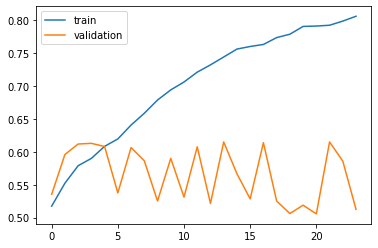

In [30]:
plot_accuracy(df_history)

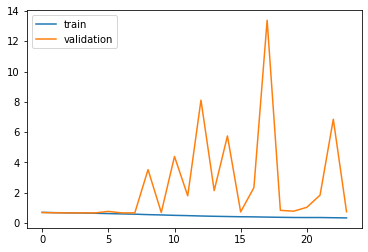

In [31]:
plot_error(df_history)

## Cargar Dataset Test

In [32]:
# Cargar dataset balanceado de test
df = func.toDF_all(glob.glob(datapath + 'test/*'), reb=False)
X_test, y_test = func.split(df, categories=num_classes, augment_data=False)
X_test = X_test / 255
del df
print(len(X_test))

592
592


## Predecir Utilizando Modelo

In [33]:
y_pred = model.predict(X_test)

## Dibujar Gráficos

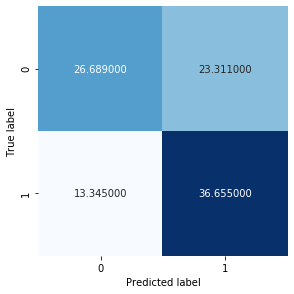

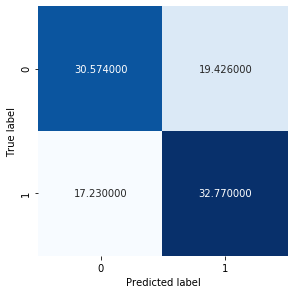

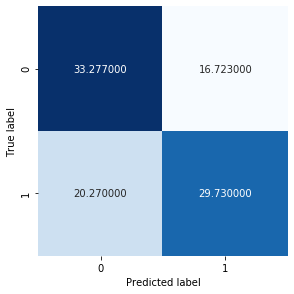

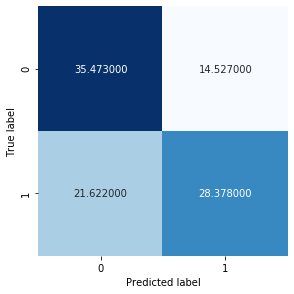

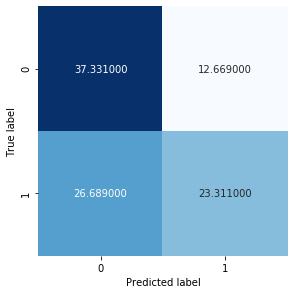

In [34]:
plot_confusion_matrix2(y_pred, output(y_test))

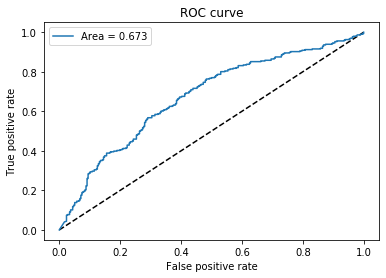

In [35]:
plot_roc_auc2(y_pred, y_test)

In [36]:
print("Accuracy: ", accuracy(output(y_pred), output(y_test)) )

Accuracy:  0.6300675675675675


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, output(y_pred, threshold=0.5)))


              precision    recall  f1-score   support

           0       0.62      0.67      0.64       296
           1       0.64      0.59      0.62       296

    accuracy                           0.63       592
   macro avg       0.63      0.63      0.63       592
weighted avg       0.63      0.63      0.63       592

